# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [4]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
# !unzip dogImages.zip # unzipped in terminal

--2023-03-24 19:44:51--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.112.240
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.112.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  17.0MB/s    in 31s     

2023-03-24 19:45:23 (34.9 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]



In [4]:
# get default s3
session = sagemaker.Session()
bucket = session.default_bucket()

print("Default S3 Bucket: ", bucket)

Default S3 Bucket:  sagemaker-us-east-1-098421563522


In [9]:
### data explore
import os
path = "dogImages/train" 
num_files = len(os.listdir(path))
print("Number of class:", num_files)

Number of class: 133


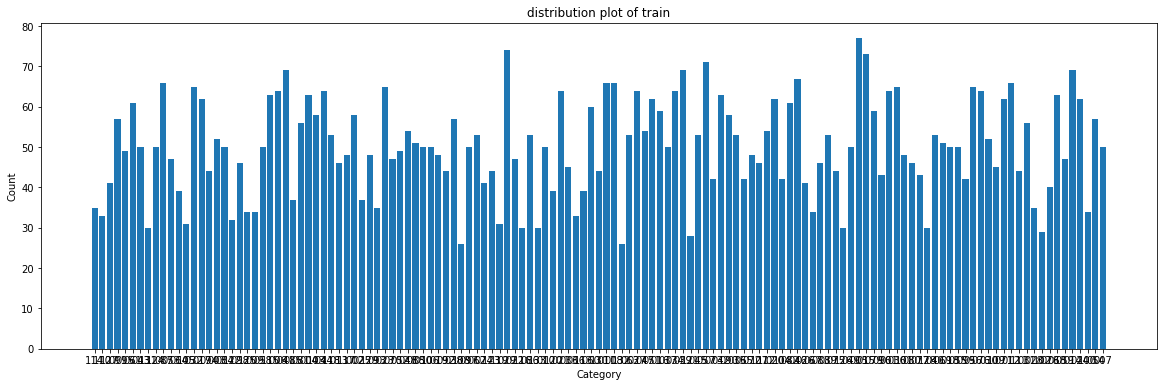

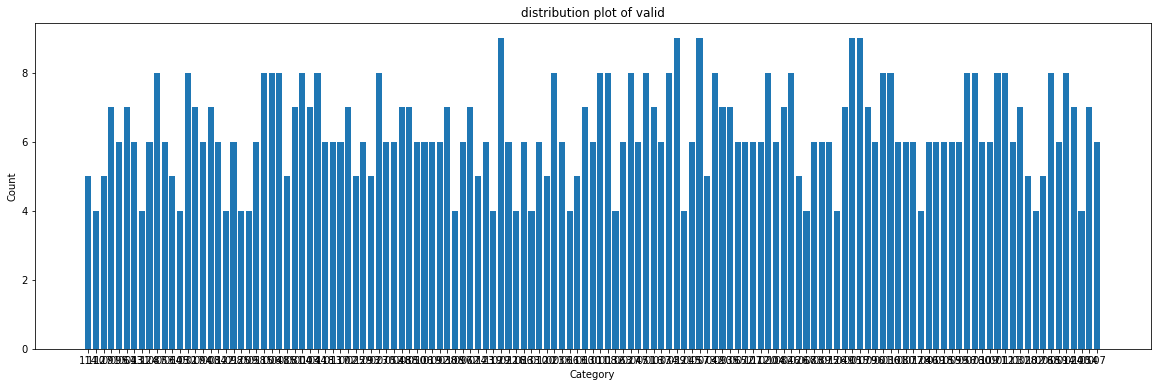

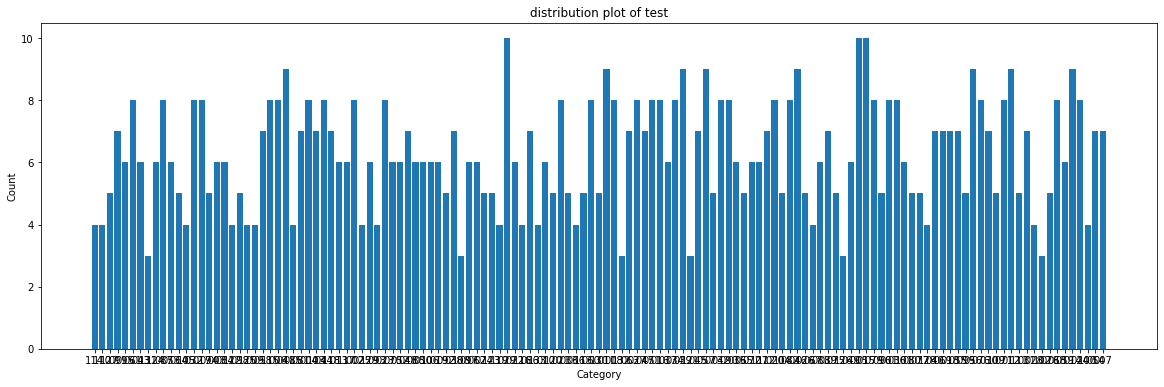

In [18]:
import matplotlib.pyplot as plt
def dist_plot(directory):
    class_dict={}
    path = f'dogImages/{directory}'
    for cate in os.listdir(path):
        cate_path = os.path.join(path,cate)
        cate = cate.split('.')[0]
        class_dict[cate] = len(os.listdir(cate_path))
    plt.figure(figsize=(20,6))
    plt.bar(class_dict.keys(), class_dict.values())
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.title(f"distribution plot of {directory}")
    plt.show()
dist_plot('train')
dist_plot('valid')
dist_plot('test')

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [32]:
#TODO: Declare your HP ranges, metrics etc.
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
role = sagemaker.get_execution_role()

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256]),
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]


In [35]:
#TODO: Create estimators for your HPs
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.xlarge"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)# TODO: Your HP tuner here

In [36]:
# TODO: Fit your HP Tuner
data_channels = {"train":f's3://{bucket}/dogImages/train/',
                 "valid":f's3://{bucket}/dogImages/valid/',
                 "test":f's3://{bucket}/dogImages/test/'
                }
tuner.fit(data_channels, wait=True) # TODO: Remember to include your data channels

...........................................................................................................!


In [37]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator() #TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-03-25 15:45:54 Starting - Preparing the instances for training
2023-03-25 15:45:54 Downloading - Downloading input data
2023-03-25 15:45:54 Training - Training image download completed. Training in progress.
2023-03-25 15:45:54 Uploading - Uploading generated training model
2023-03-25 15:45:54 Completed - Resource reused by training job: pytorch-training-230325-1540-003-6f438c4f


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"64"',
 'lr': '0.01289679615484953',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-03-25-15-40-29-116"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-098421563522/pytorch-training-2023-03-25-15-40-29-116/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [50]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile, CollectionConfig

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_config = DebuggerHookConfig(
    s3_output_path=f's3://{bucket}/output/',
    collection_configs=[
        CollectionConfig(
            name='CrossEntroyLoss_output',
            parameters={'include_regex':'CrossEntroyLoss_output.*',
                        'train.save_interval': '60',
                        'eval.save_interval': '5',
                        'predict.save_interval': '5'
                         })
    ]
)

hyperparameters = {'batch-size': '"64"','lr': '0.01289679615484953'}

In [52]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    role=role,
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    entry_point="train_model.py",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)
 # TODO: Your estimator here
estimator.fit(data_channels,
              wait=True)


ResourceLimitExceeded: An error occurred (ResourceLimitExceeded) when calling the CreateTrainingJob operation: The account-level service limit 'Number of instances across all processing jobs' is 10 Instances, with current utilization of 5 Instances and a request delta of 7 Instances. Please contact AWS support to request an increase for this limit.

In [ ]:
# TODO: Plot a debugging output.
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())


print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.PREDICT)))

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [ ]:
# TODO: Display the profiler output

## Model Deploying

In [ ]:
# TODO: Deploy your model to an endpoint

predictor=estimator.deploy() # TODO: Add your deployment configuration like instance type and number of instances

In [ ]:
# TODO: Run an prediction on the endpoint

image = # TODO: Your code to load and preprocess image to send to endpoint for prediction

response = predictor.predict(image)

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()